## Text Classification Using Convolutional Neural Networks

In [1]:
# !wget http://nlp.stanford.edu/data/glove.twitter.27B.zip
# !wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
# !unzip trainingandtestdata.zip
# !unzip glove.twitter.27B.zip

# Q4
## Use one of the word embeddings (word2vec, Glove, fasText) and build a CNN model

The above code imports TensorFlow and sets the number of threads used for inter-op parallelism to 8. It also imports various functions and classes from the keras library, including Sequential, Dense, Dropout, Activation, Embedding, Conv1D, MaxPooling1D, and Flatten. It also imports sequence and text from keras.preprocessing. 

In [2]:
import tensorflow as tf
tf.config.threading.set_inter_op_parallelism_threads(8)
from keras.preprocessing import sequence, text
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Conv1D, MaxPooling1D, Flatten
from keras_preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd

The code then reads a CSV file called 'training.1600000.processed.noemoticon.csv' using pandas, and stores the resulting DataFrame in a variable called df. The cols list specifies the names of the columns in the CSV file, which are used as the column labels in the resulting DataFrame. The tweets variable is assigned the values in the 'text' column of the DataFrame, and the target variable is assigned the values in the 'target' column. 

In [3]:
cols = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('training.1600000.processed.noemoticon.csv', sep=',',names=cols,encoding='latin-1', header=None)
# df= df.iloc[790000:810000]

tweets = df['text']
target = df['target']
del df

The target values are then mapped to 0 or 1 using a dictionary, where the value 0 is mapped to 0 and the value 4 is mapped to 1. Finally, the target.value_counts() function is used to print the counts of the unique values in the target column.

In [4]:
print(target.value_counts())
target = target.map({0:0, 4:1}).astype('int8')

0    800000
4    800000
Name: target, dtype: int64


The below code imports the gensim library and applies the simple_preprocess function to the tweets series, which tokenizes the tweets and lowercases them. It then uses the train_test_split function from scikit-learn to split the tweets and target variables into training and testing sets, with a test size of 10%.

In [5]:
import gensim
tweets = tweets.apply(gensim.utils.simple_preprocess)
tweets.head

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(tweets, target, test_size=0.1, random_state=0, stratify=target)

The code then sets several hyperparameters for the model, including the vocabulary size, maximum length of the input sequences, embedding dimension, batch size, and number of epochs. It also sets the number of filters, kernel size, and hidden dimensions for the Convolutional Neural Network (CNN) that will be used in the model.

In [6]:
# set parameters:
vocab_size = 1000
max_length = 1000 # optimal 1000
embedding_dim = 100
batch_size = 32
epochs = 6 # optimal 10
filters = 16
kernel_size = 3
hidden_dims = 250

The code then initializes a Tokenizer object with the specified vocabulary size and fits it on the training data. It then converts the training data into sequences of integers using the texts_to_sequences method and pads the sequences to the maximum length using the pad_sequences function. The padded sequences are then converted to int16 type.

In [7]:
tokenizer = text.Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_matrix(X_train)
X_test = tokenizer.texts_to_matrix(X_test)

In [8]:
X_train = pad_sequences(X_train, maxlen=max_length).astype('int16')
X_test = sequence.pad_sequences(X_test, maxlen=max_length).astype('int16')

The below code initializes an empty dictionary called Embedding_index and opens the file 'glove.twitter.27B.100d.txt', which is a file containing pre-trained GloVe word embeddings. The code then reads the file line by line, splits each line into a list of values using the split method, and assigns the first element of the list (the word) to the word variable and the rest of the elements (the word embeddings) to the coefs variable. The coefs variable is then converted to a NumPy array using the asarray function. The Embedding_index dictionary is then updated with the word and its corresponding word embeddings. The file is then closed.

In [10]:
Embedding_index = {}
f = open('glove.twitter.27B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    Embedding_index[word] = coefs
f.close()

The code then initializes a NumPy array called Embedding_matrix with dimensions vocab_size by embedding_dim and fills it with zeros. It then iterates over the items in the tokenizer.word_index dictionary, which maps words to their indices in the vocabulary. For each word, the code checks if its index is less than the vocabulary size. If it is, it looks up the word in the Embedding_index dictionary to get its word embeddings, and assigns these embeddings to the corresponding row in the Embedding_matrix array. If the index is greater than or equal to the vocabulary size, the loop breaks.

In [11]:
Embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i > vocab_size - 1:
        break
    else:
        embedding_vector = Embedding_index.get(word)
        if embedding_vector is not None:
            Embedding_matrix[i] = embedding_vector

In [12]:
del Embedding_index, tokenizer
del   tweets, target

The above code defines a CNN model using the Sequential class from Keras. The model consists of an Embedding layer, followed by two Conv1D layers, two MaxPooling1D layers, a Flatten layer, a Dense layer with hidden_dims units and a ReLU activation function, a Dropout layer with a rate of 0.5, and a final Dense layer with a single unit and a sigmoid activation function. The Embedding layer takes the vocabulary size, embedding dimension, and input length as arguments, and is initialized with the Embedding_matrix array and set to not be trainable. The Conv1D layers have a specified number of filters and kernel size, and use a 'valid' padding. They use a 'relu' activation function. The MaxPooling1D layers have no arguments. The Dense layers have the specified number of units and use a 'relu' or 'sigmoid' activation function. The Dropout layer has a rate of 0.5.

In [13]:
model = Sequential()

# model.add(Embedding(vocab_size, embedding_dim, input_length=max_length ))
# model.add(Dropout(0.5))


model.add(Embedding(vocab_size, embedding_dim, input_length=max_length, trainable=False, weights=[Embedding_matrix]))
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters, kernel_size, padding='valid', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(hidden_dims, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

The model is then compiled with a 'binary_crossentropy' loss function, the 'adam' optimizer, and the 'accuracy' metric. It is then trained on the training data using the fit method, with the specified number of epochs and batch size, and the validation data is passed as an argument.

In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, )

2022-12-23 18:55:02.699826: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/6
45000/45000 [==============================] - 1132s 25ms/step - loss: 0.4960 - accuracy: 0.7577 - val_loss: 0.4701 - val_accuracy: 0.7733
Epoch 2/6
45000/45000 [==============================] - 1091s 24ms/step - loss: 0.4756 - accuracy: 0.7716 - val_loss: 0.4650 - val_accuracy: 0.7782
Epoch 3/6
45000/45000 [==============================] - 1114s 25ms/step - loss: 0.4685 - accuracy: 0.7766 - val_loss: 0.4622 - val_accuracy: 0.7787
Epoch 4/6
45000/45000 [==============================] - 1106s 25ms/step - loss: 0.4638 - accuracy: 0.7793 - val_loss: 0.4611 - val_accuracy: 0.7800
Epoch 5/6
45000/45000 [==============================] - 1130s 25ms/step - loss: 0.4605 - accuracy: 0.7815 - val_loss: 0.4619 - val_accuracy: 0.7797
Epoch 6/6
45000/45000 [==============================] - 1101s 24ms/step - loss: 0.4583 - accuracy: 0.7831 - val_loss: 0.4595 - val_accuracy: 0.7807


The below code uses the plot function from the matplotlib library (imported as plt) to generate a line plot of the accuracy of a model as it was trained over a series of epochs. The plot is given a title ('model accuracy') and labels for the y-axis ('accuracy') and x-axis ('epoch'). The history object being plotted is assumed to contain the training and test accuracy for each epoch. The legend function is used to specify that the line for the 'train' data should be labeled as such and the line for the 'test' data should be labeled as such. The show function is then called to display the plot.

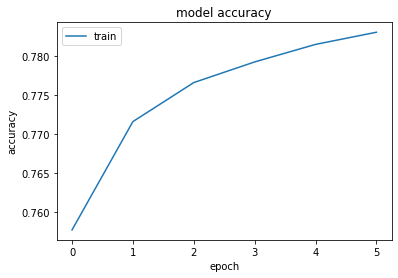

In [16]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The model is then used to make predictions on the testing data using the predict method, and the resulting predictions are stored in the y_pred variable.

In [17]:
# prediction
y_pred = model.predict(X_test)

In [1]:
# accuracy
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred.round()))

NameError: name 'y_test' is not defined

KNN - 0.66
SVM - 0.76
Desision Tree - 0.66

CNN - 78

:- When considering accuracy CNN is better than other three.